<a href="https://colab.research.google.com/github/vishrut2104/cardiac-cycle-tracking/blob/main/final_heart_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, TimeDistributed, Reshape, ConvLSTM2D
import keras
import matplotlib.pyplot as plt


In [ ]:
# Load the input data masks from the saved file
input_data_masks = np.load('/content/drive/My Drive/UoG/input_data_masks.npy')

In [ ]:
# Some if the input data masks have a couple of blank frames, which may be detrimental to our frame generation model.
# Hence I have manually removed them by filtering the data.
indices_to_remove = [0, 1, 5, 11, 18, 28, 35, 39, 45, 52, 66, 67, 73, 76, 93, 96]
filtered_input_data_masks = [data for idx, data in enumerate(input_data_masks) if idx not in indices_to_remove]


Now we will split the data into two arrays, one with first five frames and the other with the last frame.

The first five frames data will be used to train the model whereas the last frame of each patient will be used as the ground truth label for the frame prediction model

In [ ]:
input_data_masks_array = np.array(filtered_input_data_masks)
first_five_frames_data = input_data_masks_array[:, :, :, :5]
last_frame_data = input_data_masks_array[:, :, :, -1:]

At some point in the future, we will be using convLSTM2D layer, which expects the input in a 5 dimensional shape. Therefore, we will now reshape the data into a 5 dimensional array so that it can be fed to the model without any problems

In [ ]:
reshaped_data = np.zeros((83, 5, 128, 128, 1))

for i in range(83):
    for j in range(5):
        frame = np.expand_dims(first_five_frames_data[i, :, :, j], axis=-1)
        reshaped_data[i, j, :, :, :] = frame

In [ ]:
reshaped_last_frame_data = np.zeros((83, 1, 128, 128, 1))

for i in range(83):
    for j in range(1):
        frame = np.expand_dims(last_frame_data[i, :, :, j], axis=-1)
        reshaped_last_frame_data[i, j, :, :, :] = frame

Randomly splitting data into training and validation sets.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(reshaped_data, reshaped_last_frame_data, test_size=0.2, random_state=42)

#Conv LSTM model


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, TimeDistributed, Reshape, ConvLSTM2D
import keras

inp = Input(shape=(5, 128, 128, 1))

# First we will define the CNN model with 64 5x5 kernels
cnn = TimeDistributed(Conv2D(filters=64, kernel_size=(5, 5), padding="same", activation="relu"))(inp)
cnn = TimeDistributed(BatchNormalization())(cnn)
cnn = TimeDistributed(Conv2D(filters=64, kernel_size=(5, 5), padding="same", activation="relu"))(cnn)
cnn = TimeDistributed(BatchNormalization())(cnn)

# Wrap the CNN model inside LSTM model
x = ConvLSTM2D(
    filters=1,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=False,
    activation="relu",
)(cnn)

x = Reshape((1, 128, 128, 1))(x)
model = Model(inp, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(),
)
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 128, 128, 1)]  0         
                                                                 
 time_distributed_16 (TimeDi  (None, 5, 128, 128, 64)  1664      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 5, 128, 128, 64)  256       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 5, 128, 128, 64)  102464    
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 5, 128, 128, 64)  256       
 stributed)                                                

For a  relatively small model, this CNN-LSTM model has a large number of parameters. This may be detrimental to our limited GPU resources.

Epoch 1/20
17/17 [==============================] - 1s 83ms/step - loss: 0.0183 - val_loss: 0.0193
Epoch 2/20
17/17 [==============================] - 1s 82ms/step - loss: 0.0185 - val_loss: 0.0198
Epoch 3/20
17/17 [==============================] - 1s 78ms/step - loss: 0.0195 - val_loss: 0.0224
Epoch 4/20
17/17 [==============================] - 1s 78ms/step - loss: 0.0206 - val_loss: 0.0229
Epoch 5/20
17/17 [==============================] - 1s 77ms/step - loss: 0.0297 - val_loss: 0.0290
Epoch 6/20
17/17 [==============================] - 1s 78ms/step - loss: 0.0329 - val_loss: 0.0281
Epoch 7/20
17/17 [==============================] - 2s 92ms/step - loss: 0.0311 - val_loss: 0.0264
Epoch 8/20
17/17 [==============================] - 2s 96ms/step - loss: 0.0320 - val_loss: 0.0403
Epoch 9/20
17/17 [==============================] - 1s 82ms/step - loss: 0.0353 - val_loss: 0.0323
Epoch 10/20
17/17 [==============================] - 1s 81ms/step - loss: 0.0266 - val_loss: 0.0314
Epoch 11/

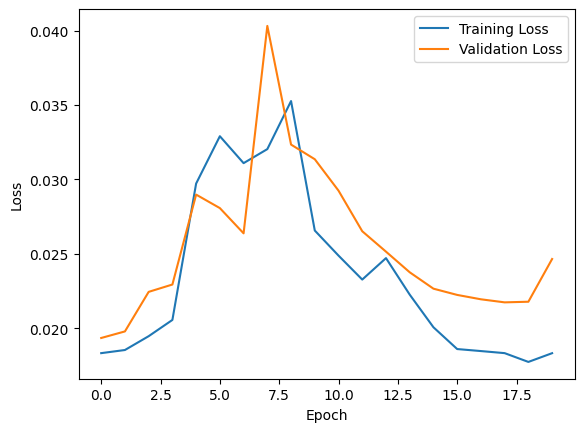

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=4,
    epochs=20,
    validation_data=(x_val, y_val)
    callbacks = [early_stopping]
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
predicted_labels = model.predict(x_val)

1/1 [==============================] - 0s 24ms/step


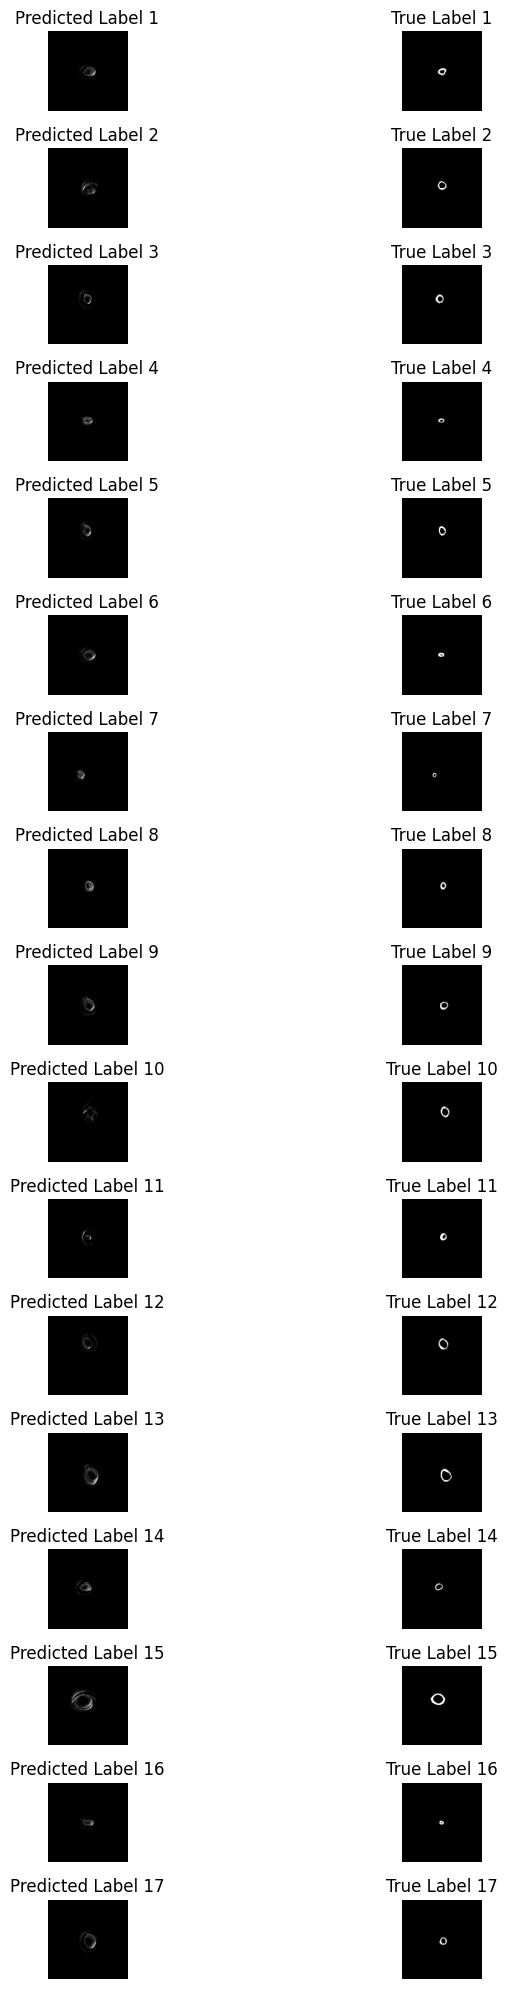

In [ ]:
# Plotting the predicted results and ground truth frames side by side
fig, axes = plt.subplots(len(predicted_labels), 2, figsize=(10, 20))
for idx, (predicted, true) in enumerate(zip(predicted_labels, y_val)):

    axes[idx, 0].imshow(np.squeeze(predicted), cmap="gray")
    axes[idx, 0].set_title(f"Predicted Label {idx + 1}")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(np.squeeze(true), cmap="gray")
    axes[idx, 1].set_title(f"True Label {idx + 1}")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()


As you can see, the model is able to capture the features of the ground truth frames, along with the pattern of the myocardium muscle getting smaller.

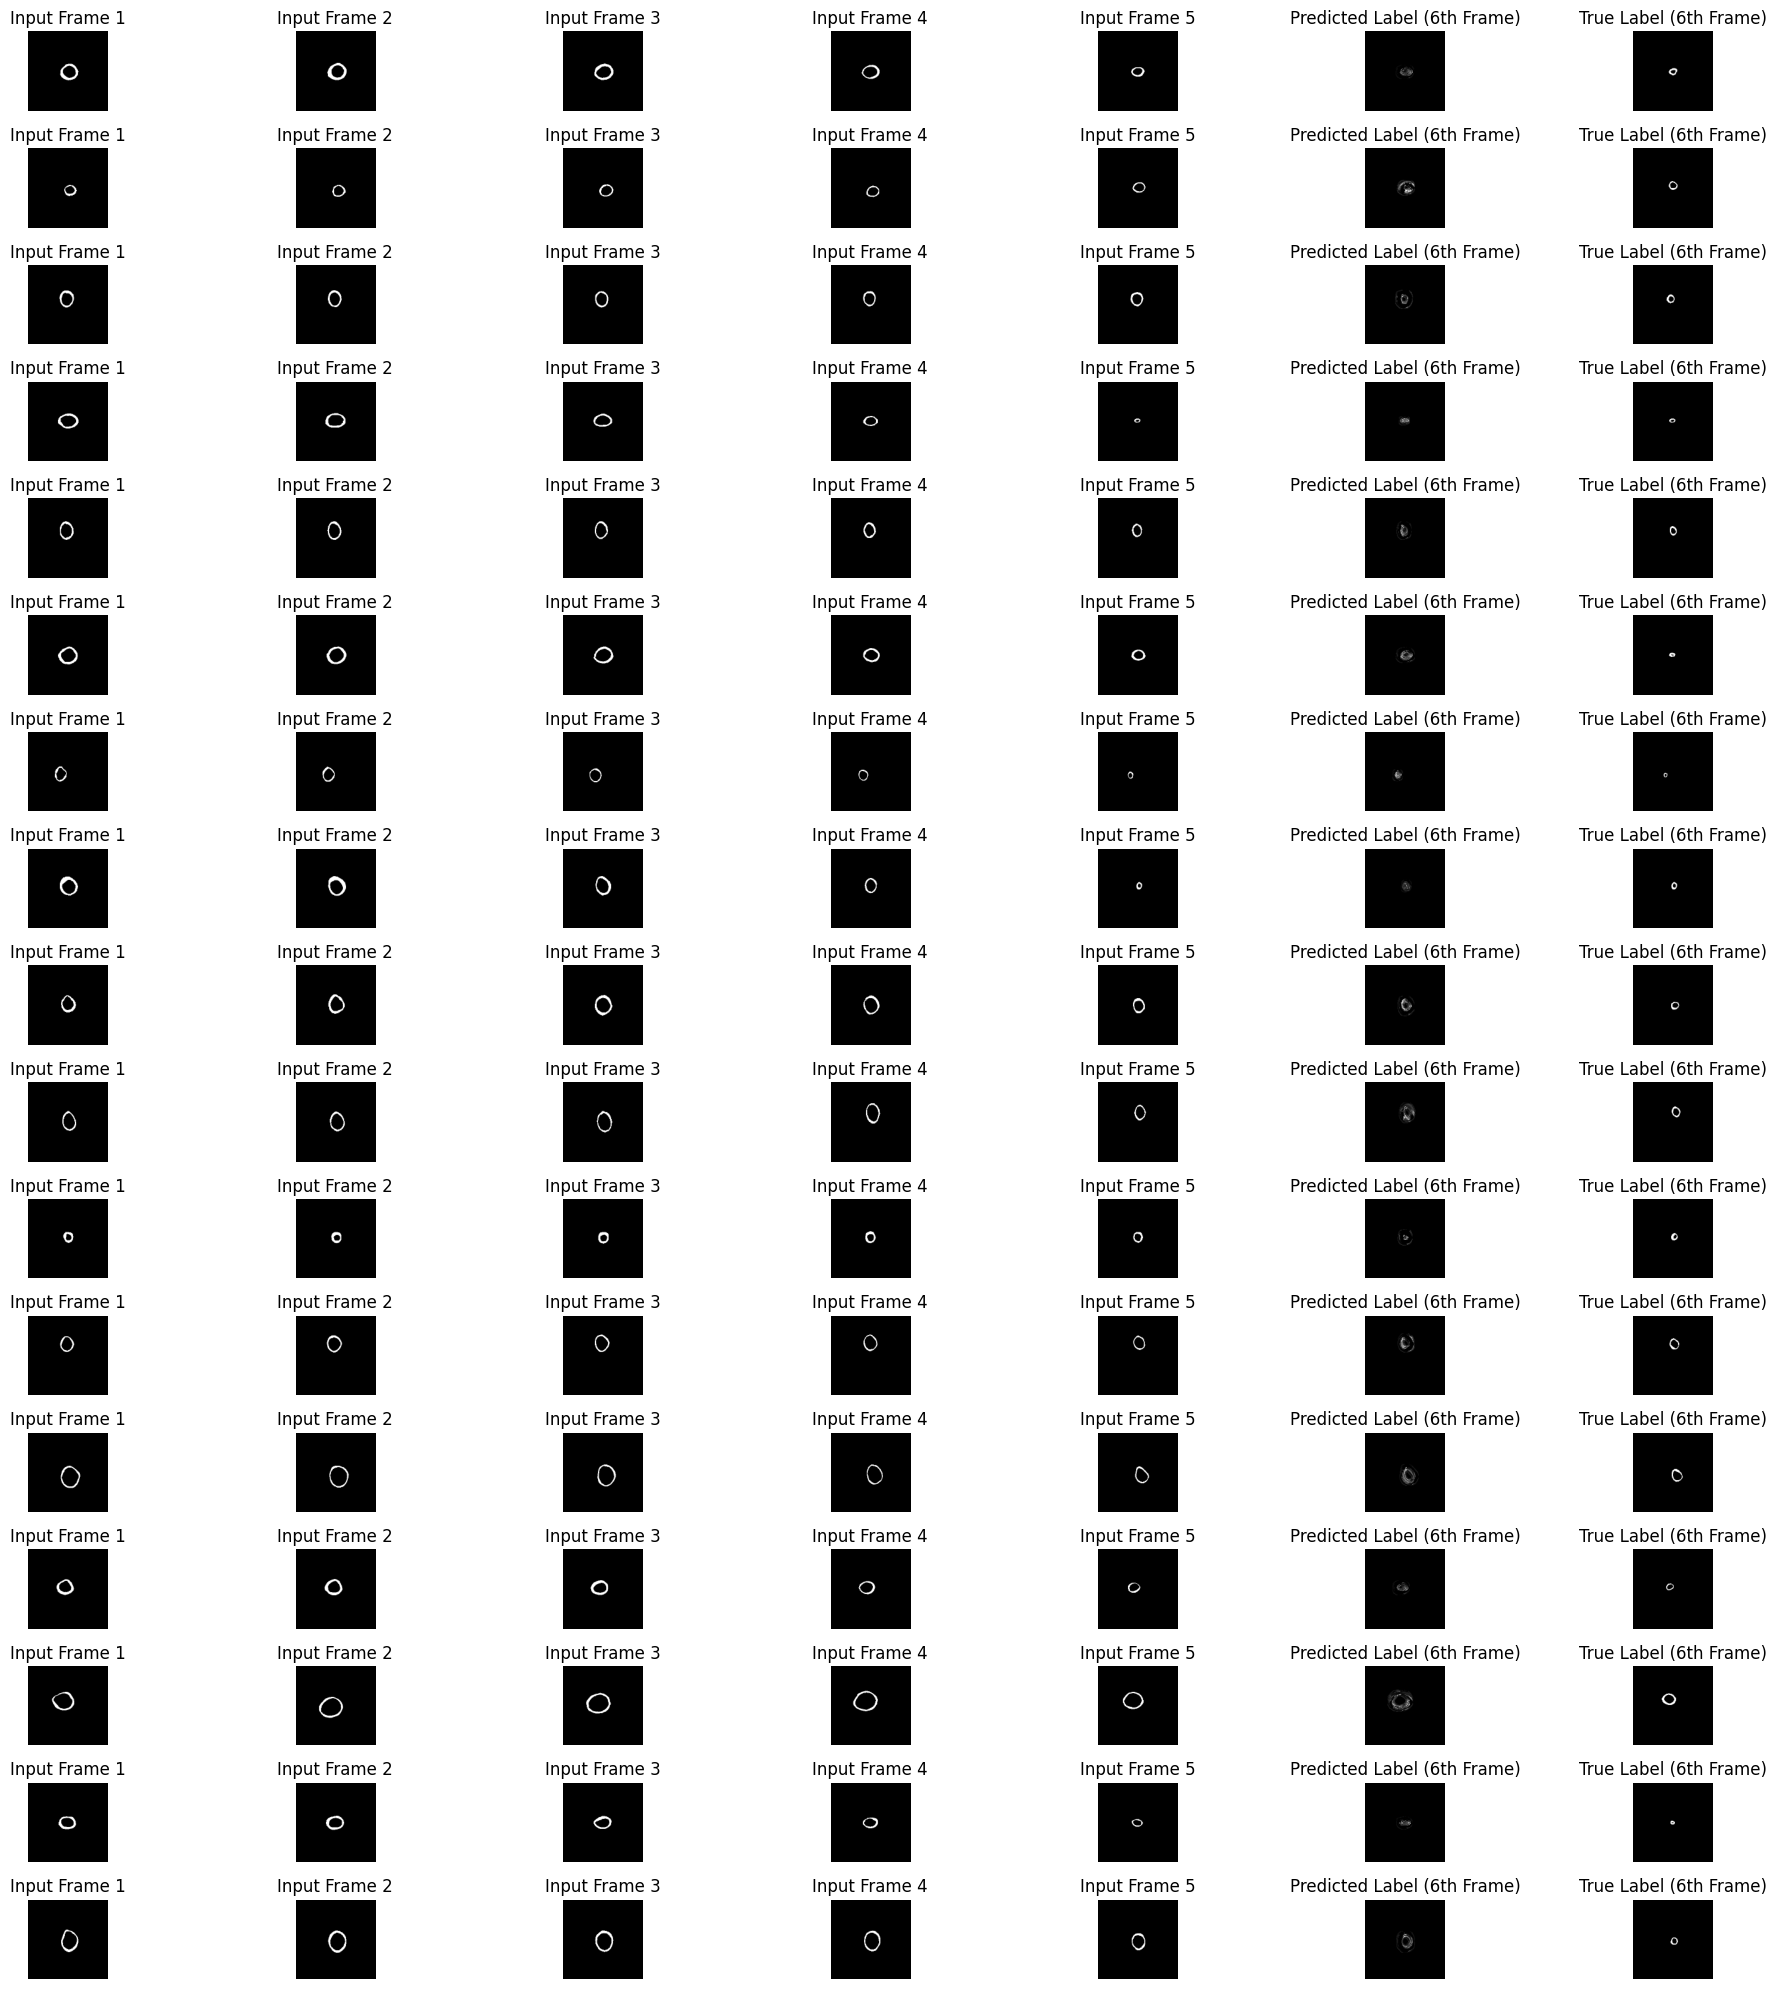

In [ ]:
#Plotting the sequence of the myocardium muscle with the predicted frame
num_samples = len(predicted_labels)
fig, axes = plt.subplots(num_samples, 7, figsize=(20, 20))

for idx in range(num_samples):
    for i in range(5):
        axes[idx, i].imshow(np.squeeze(x_val[idx, i]), cmap="gray")
        axes[idx, i].set_title(f"Input Frame {i + 1}")
        axes[idx, i].axis("off")

    axes[idx, 5].imshow(np.squeeze(predicted_labels[idx]), cmap="gray")
    axes[idx, 5].set_title("Predicted Label (6th Frame)")
    axes[idx, 5].axis("off")

    axes[idx, 6].imshow(np.squeeze(y_val[idx]), cmap="gray")
    axes[idx, 6].set_title("True Label (6th Frame)")
    axes[idx, 6].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Saving the model for future use
model.save("/content/drive/My Drive/UoG/model_zoo/cnnlstm_model7")

In [ ]:
# Saving the predictions for future use
np.save('/content/drive/My Drive/UoG/model_zoo/predicted_masks_3.npy', predicted_labels)


In [ ]:
# Calculating the PSNR score (Peak Signal to noise ratio). This use is one of the most commonly used evaluation metric for frame generation models/
scores = []
for i in range(len(y_val)):
    scores.append(psnr(y_val[i, ..., 0], predicted_labels[i, ..., 0], data_range=y_val[i, ..., 0].max() - y_val[i, ..., 0].min()))

avg_psnr = np.mean(scores)
print(f"Mean Peak Signal-to-Noise Ratio (PSNR): {avg_psnr:.4f}")

Mean Peak Signal-to-Noise Ratio (PSNR): 25.4803


In [ ]:
# Load the predicted masks from the saved file
predicted_labels = np.load('/content/drive/My Drive/UoG/model_zoo/predicted_masks_3.npy')

In [ ]:
# Now we will calculate SSIM (Structural Similarity Index). It is another commonly used metric for measuring similarity between two images.
ssim_scores = []
for pred_label, true_label in zip(predicted_labels, y_val):
    pred_label = (pred_label.squeeze() * 255).astype(np.uint8)
    true_label = (true_label.squeeze() * 255).astype(np.uint8)

    ssim = compare_ssim(true_label, pred_label, data_range=true_label.max() - true_label.min())
    ssim_scores.append(ssim)

avg_ssim = np.mean(ssim_scores)
print(f"Average SSIM: {avg_ssim:.4f}")


Average SSIM: 0.9482


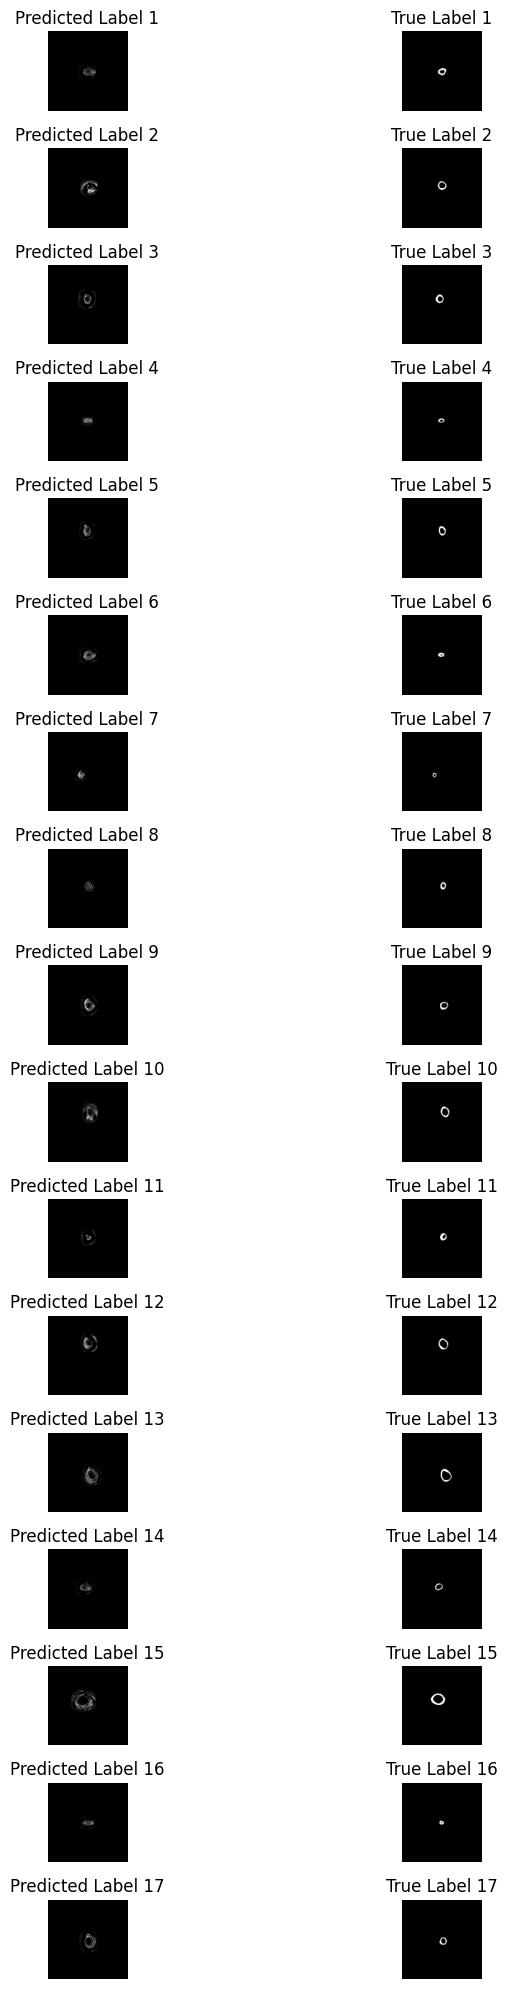

In [ ]:
fig, axes = plt.subplots(len(predicted_labels), 2, figsize=(10, 20))

for idx, (predicted, true) in enumerate(zip(predicted_labels, y_val)):
    axes[idx, 0].imshow(np.squeeze(predicted), cmap="gray")
    axes[idx, 0].set_title(f"Predicted Label {idx + 1}")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(np.squeeze(true), cmap="gray")
    axes[idx, 1].set_title(f"True Label {idx + 1}")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()

Lets try to introduce some minor changes to our model and see if we can get better results

In [ ]:
# Setting the input shape
inp = Input(shape=(5, 128, 128, 1))

# Lets try a different model with 128 kernels instead of 64.
cnn = TimeDistributed(Conv2D(filters=128, kernel_size=(5, 5), padding="same", activation="relu"))(inp)
cnn = TimeDistributed(BatchNormalization())(cnn)
cnn = TimeDistributed(Conv2D(filters=128, kernel_size=(5, 5), padding="same", activation="relu"))(cnn)
cnn = TimeDistributed(BatchNormalization())(cnn)

# Wrap the CNN model in LSTM
x = ConvLSTM2D(
    filters=1,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=False,
    activation="relu",
)(cnn)

x = Reshape((1, 128, 128, 1))(x)
model = Model(inp, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(),
)

model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 128, 128, 1)]  0         
                                                                 
 time_distributed_12 (TimeDi  (None, 5, 128, 128, 128)  3328     
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 5, 128, 128, 128)  512      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 5, 128, 128, 128)  409728   
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 5, 128, 128, 128)  512      
 stributed)                                                

As you can see, this model has much more trainaible parameters than the previous one due to increased filters.

In [ ]:
# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=8,
    epochs=20,
    validation_data=(x_val, y_val)
)


Epoch 1/20
9/9 [==============================] - 3s 276ms/step - loss: 0.0296 - val_loss: 0.0548
Epoch 2/20
9/9 [==============================] - 2s 265ms/step - loss: 0.0285 - val_loss: 0.0583
Epoch 3/20
9/9 [==============================] - 2s 266ms/step - loss: 0.0280 - val_loss: 0.0636
Epoch 4/20
9/9 [==============================] - 2s 266ms/step - loss: 0.0274 - val_loss: 0.0630
Epoch 5/20
9/9 [==============================] - 3s 289ms/step - loss: 0.0270 - val_loss: 0.0696
Epoch 6/20
9/9 [==============================] - 3s 292ms/step - loss: 0.0269 - val_loss: 0.0639
Epoch 7/20
9/9 [==============================] - 2s 269ms/step - loss: 0.0264 - val_loss: 0.0597
Epoch 8/20
9/9 [==============================] - 3s 285ms/step - loss: 0.0259 - val_loss: 0.0614
Epoch 9/20
9/9 [==============================] - 3s 285ms/step - loss: 0.0255 - val_loss: 0.0602
Epoch 10/20
9/9 [==============================] - 2s 266ms/step - loss: 0.0259 - val_loss: 0.0562
Epoch 11/20
9/9 [==

In [ ]:
predicted_labels = model.predict(x_val)

1/1 [==============================] - 0s 26ms/step


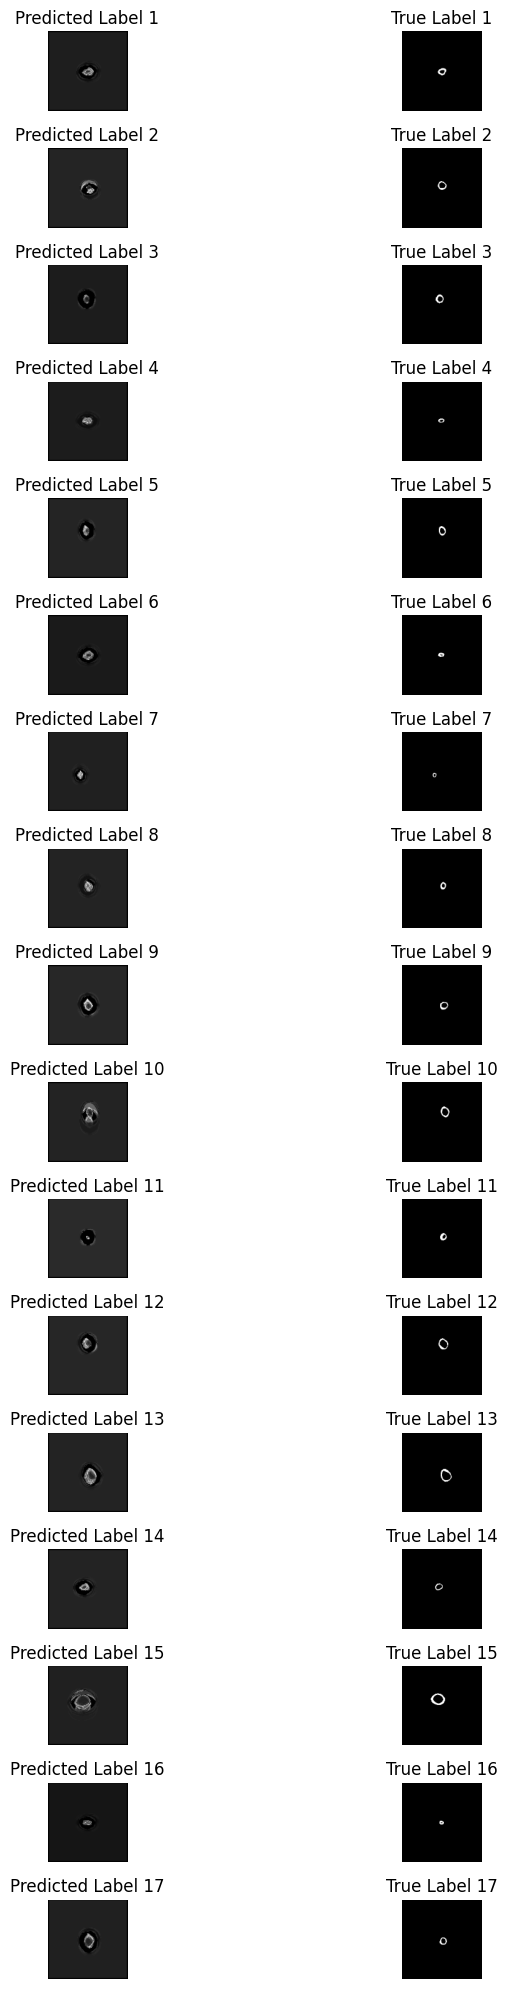

In [ ]:
fig, axes = plt.subplots(len(predicted_labels), 2, figsize=(10, 20))

for idx, (predicted, true) in enumerate(zip(predicted_labels, y_val)):

    axes[idx, 0].imshow(np.squeeze(predicted), cmap="gray")
    axes[idx, 0].set_title(f"Predicted Label {idx + 1}")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(np.squeeze(true), cmap="gray")
    axes[idx, 1].set_title(f"True Label {idx + 1}")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# saving the predictions and the model for future use.
np.save('/content/drive/My Drive/UoG/predicted_masks_4.npy', predicted_masks)
model.save("/content/drive/My Drive/UoG/model_zoo/cnnlstmmodel_8")

In [ ]:
# Training the model more
history = model.fit(
    x_train, y_train,
    batch_size=8,
    epochs=5,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
)

Epoch 1/5
9/9 [==============================] - 3s 279ms/step - loss: 0.0291 - val_loss: 0.0738
Epoch 2/5
9/9 [==============================] - 2s 273ms/step - loss: 0.0288 - val_loss: 0.0570
Epoch 3/5
9/9 [==============================] - 2s 266ms/step - loss: 0.0287 - val_loss: 0.0542
Epoch 4/5
9/9 [==============================] - 2s 267ms/step - loss: 0.0284 - val_loss: 0.0410
Epoch 5/5
9/9 [==============================] - 3s 283ms/step - loss: 0.0281 - val_loss: 0.0291


In [ ]:
predicted_labels = model.predict(x_val)

1/1 [==============================] - 0s 28ms/step


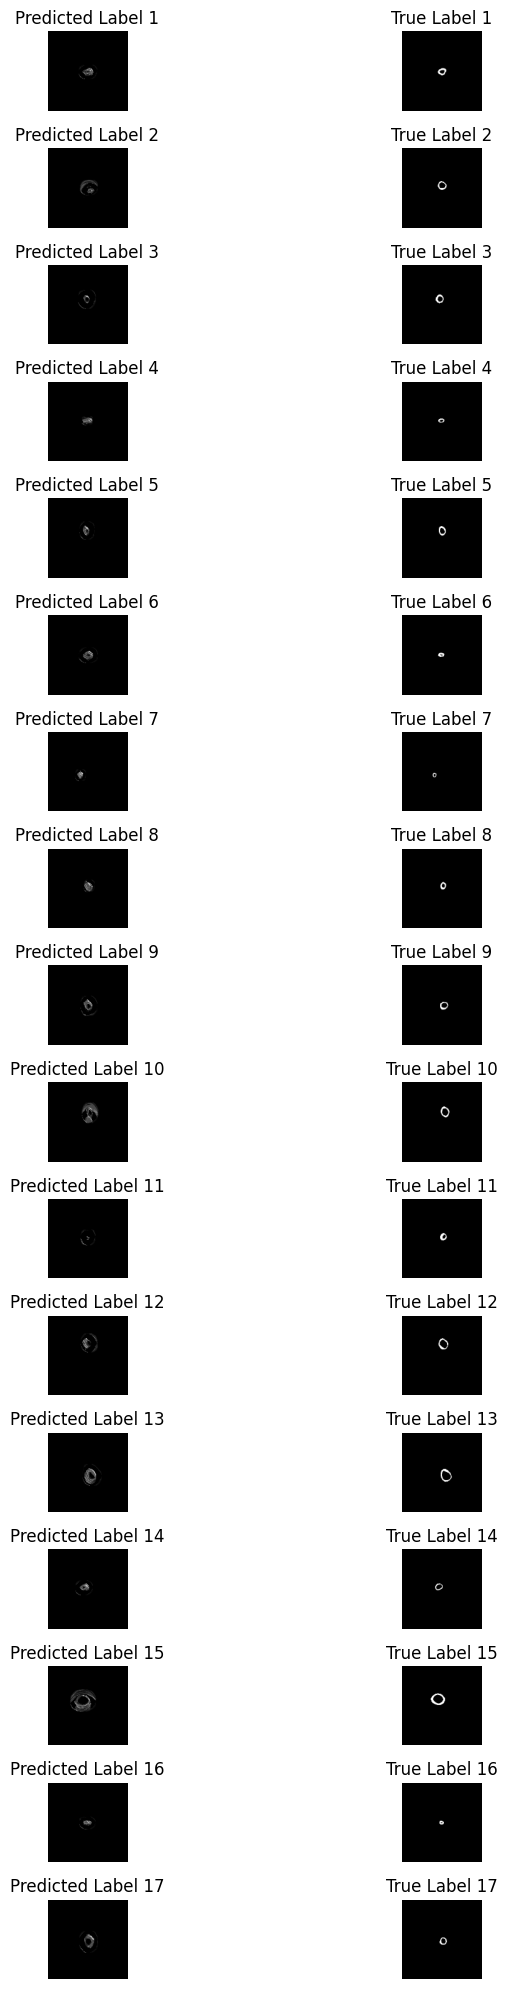

In [ ]:
fig, axes = plt.subplots(len(predicted_labels), 2, figsize=(10, 20))

for idx, (predicted, true) in enumerate(zip(predicted_labels, y_val)):
    axes[idx, 0].imshow(np.squeeze(predicted), cmap="gray")
    axes[idx, 0].set_title(f"Predicted Label {idx + 1}")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(np.squeeze(true), cmap="gray")
    axes[idx, 1].set_title(f"True Label {idx + 1}")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
np.save('/content/drive/My Drive/UoG/predicted_masks_8.npy', predicted_masks)

In [ ]:
model.save("/content/drive/My Drive/UoG/model_zoo/cnnlstmmodel_9")

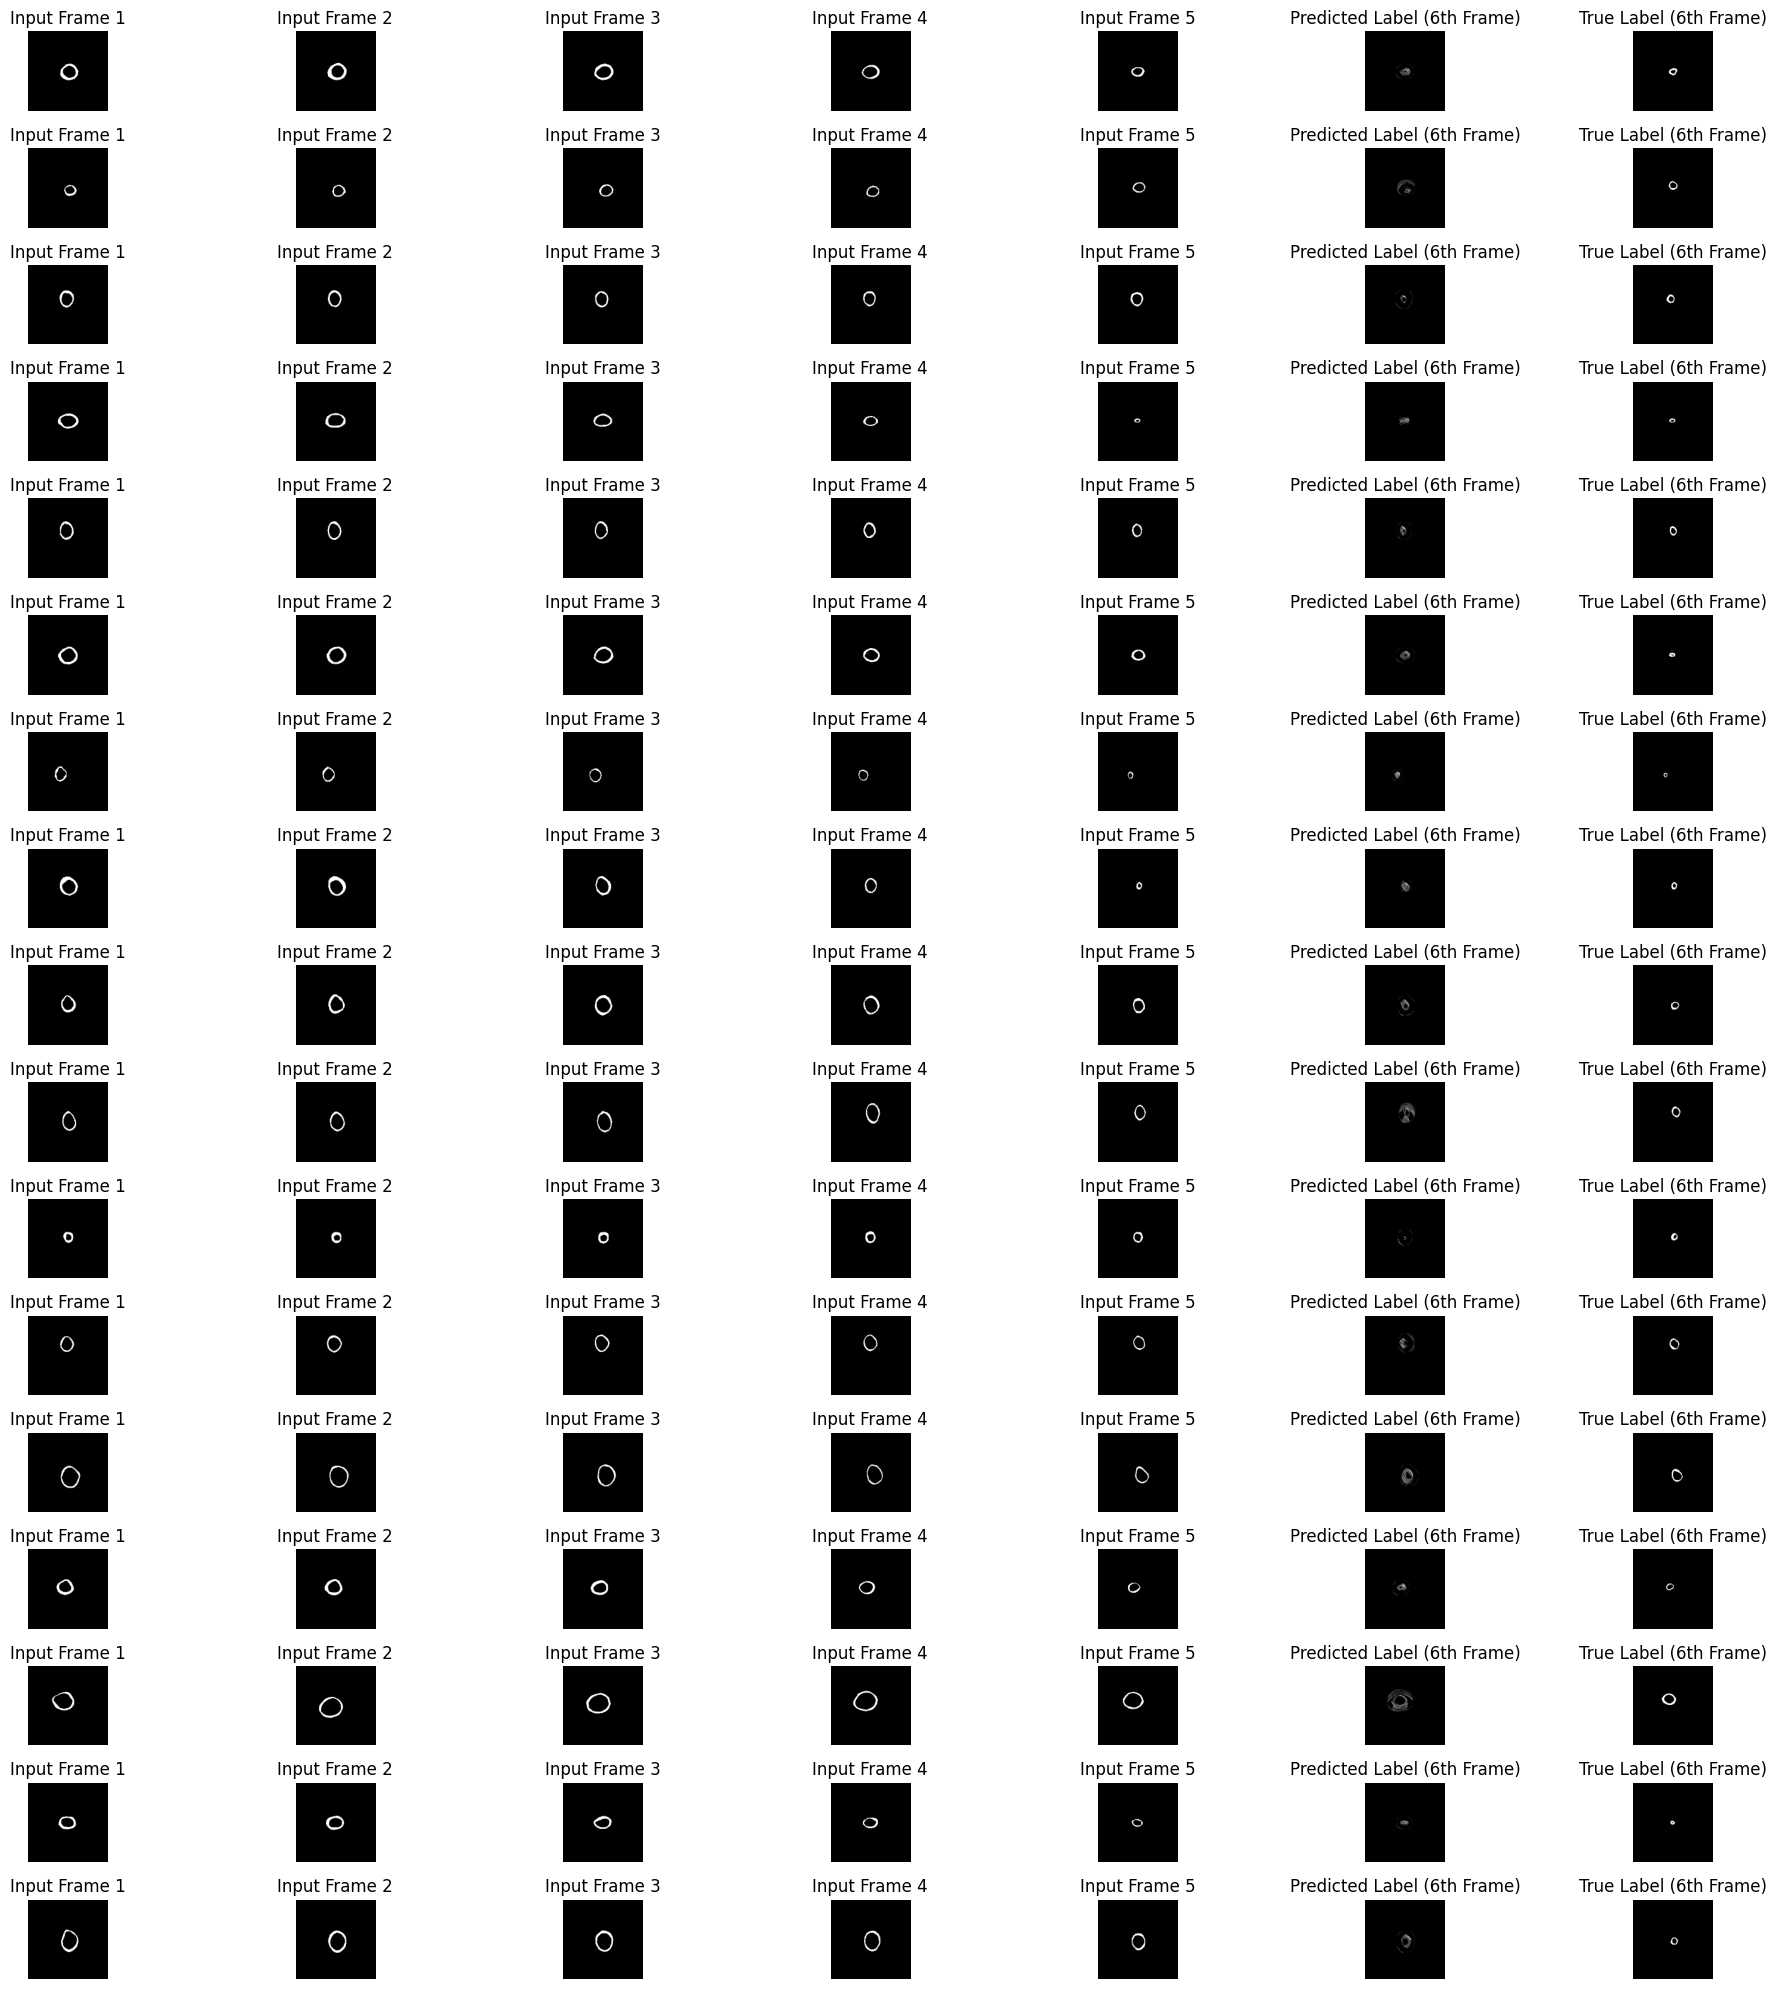

In [ ]:
#Visualising the new predictions along with the first five frames and the ground truth frame

num_samples = len(predicted_labels)
fig, axes = plt.subplots(num_samples, 7, figsize=(20, 20))

for idx in range(num_samples):
    # Plot input frames
    for i in range(5):
        axes[idx, i].imshow(np.squeeze(x_val[idx, i]), cmap="gray")
        axes[idx, i].set_title(f"Input Frame {i + 1}")
        axes[idx, i].axis("off")

    # Plot predicted label (6th frame)
    axes[idx, 5].imshow(np.squeeze(predicted_labels[idx]), cmap="gray")
    axes[idx, 5].set_title("Predicted Label (6th Frame)")
    axes[idx, 5].axis("off")

    # Plot true label (6th frame)
    axes[idx, 6].imshow(np.squeeze(y_val[idx]), cmap="gray")
    axes[idx, 6].set_title("True Label (6th Frame)")
    axes[idx, 6].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
ssim_scores = []
for pred_label, true_label in zip(predicted_labels, y_val):

    pred_label = (pred_label.squeeze() * 255).astype(np.uint8)
    true_label = (true_label.squeeze() * 255).astype(np.uint8)
    ssim = compare_ssim(true_label, pred_label, data_range=true_label.max() - true_label.min())
    ssim_scores.append(ssim)

avg_ssim = np.mean(ssim_scores)
print(f"Average SSIM: {avg_ssim:.4f}")

Average SSIM: 0.9475


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_scores = []
for i in range(len(y_val)):
    psnr_scores.append(psnr(y_val[i, ..., 0], predicted_labels[i, ..., 0], data_range=y_val[i, ..., 0].max() - y_val[i, ..., 0].min()))

avg_psnr = np.mean(psnr_scores)
print(f"Mean Peak Signal-to-Noise Ratio (PSNR): {avg_psnr:.4f}")

Mean Peak Signal-to-Noise Ratio (PSNR): 25.3976


In [ ]:
mse = np.mean(np.square(y_val - predicted_labels))
print(f'Mean Squared Error (MSE): {mse:.4f}')


Mean Squared Error (MSE): 0.0033


The evaluation metrics tell us that both the predictions are similar and are able to correctly capture the pattern of the ground truth labels. Visually, the predictions seems satisfactory while keeping in mind the limited data that we had (83 patients). Moreover, only 5 frames were available for training for each patient. However, we can successfully say that CNN-LSTM model is capable of capuring

#Model 1

The first model architecture has two time distributed Conv2d layers.Each layer as 64 5x5 convolutional filters and each layer is separated by batch normalisation to help reduce overfitting.

Finally, a ConvLSTM2D layer with 1x1 filter is utilised to capture the time dependencies of the data and generate the predcited frame.

#  Model 2

The second model architecture is somewhat similar to the first one, however, in the CNN part, it has 128 filters instead of 64 as part of experimenting with the model.  

Both the models boast a high SSIM and good PSNR score. They showcase that CNN-LSTM is able to generate myocardium frames using their binary masks. However, there is still room for improvement. Experimenting is a big part of building deep learning models.

I have experimented with various loss functions, activation layers, optimsers and architectures. I will include all of these in my dissertation. However, the models presented above were able to get the best results.